## Import the necessary modules
We use the following modules that are pre-installed in the Anaconda Installer.<br>
1)Matplotlib<br>
2)Numpy<br>
3)Pandas<br>
4)Sklearn<br>
The following packages were manually installed (with permission granted to do so via my email on 23 June 2020). The following packages can be installed using the corresponding command in parentheses.<br>
5)Keras (conda install -c conda-forge keras)<br>
6)OpenCV (pip install opencv-python)<br>
7)Tensorflow(conda create -n tf tensorflow , thereafter, conda activate tf). Note, these commands will install the CPU-version of tensorflow. Should you already have tensorflow install, the last command of the next cell will ensure that a CPU implementation is executed.<br>


In [1]:
import os
import numpy as np
import cv2 as cv
import pandas as pd
import itertools
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Dropout, Flatten
from keras.utils.np_utils import to_categorical
from keras.models import load_model
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
#Once tensorflow is installed, we use the following command to ensure that a 
#CPU-implementation is used
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.
C:\Users\mayur\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mayur\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mayur\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mayur\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

Define the necessary global variables

In [2]:
background = None
global history
global hand_hist
global s
global is_hand_hist_created
global no_frames

traverse_point = []
total_rectangle = 9
hand_rect_one_x = None
hand_rect_one_y = None
hand_rect_two_x = None
hand_rect_two_y = None

Define the function to draw the 9 green rectangles required to perform background removal.

In [3]:
def draw_rect(image_frame):
    global total_rectangle, hand_rect_one_x, hand_rect_one_y, hand_rect_two_x, hand_rect_two_y
    hand_rect_one_x = np.array(
        [130, 130, 130, 180, 180, 180, 230, 230, 230], dtype=np.uint32)

    hand_rect_one_y = np.array(
        [125, 150, 175, 125, 150, 175, 125, 150, 175, ], dtype=np.uint32)

    hand_rect_two_x = hand_rect_one_x + 15
    hand_rect_two_y = hand_rect_one_y + 15

    for i in range(total_rectangle):
        cv.rectangle(image_frame, (hand_rect_one_y[i], hand_rect_one_x[i]),
                     (hand_rect_two_y[i], hand_rect_two_x[i]),
                     (0, 255, 0), 1)
    return image_frame

Define the function to compute the histogram of the hand used to perform background removal.

In [4]:
def hand_histogram(frame):
    global hand_rect_one_x, hand_rect_one_y

    hsv_frame = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    roi = np.zeros([90, 10, 3], dtype=hsv_frame.dtype)

    for i in range(total_rectangle):
        roi[i * 10: i * 10 + 10, 0: 10] = hsv_frame[hand_rect_one_x[i]:hand_rect_one_x[i] + 10,
                                          hand_rect_one_y[i]:hand_rect_one_y[i] + 10]

    # Quantize the hue to 180 levels and the saturation to 256 levels.
    # we set the range of the hue to span [0,180] and the saturation to [0,255]
    hand_hist = cv.calcHist([roi], [0, 1], None, [180, 256], [0, 180, 0, 256])
    return cv.normalize(hand_hist, hand_hist, 0, 255, cv.NORM_MINMAX)

Define the function that removes the background from the given 'image'/ video frame.

In [5]:
def hist_masking(frame, hist):
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    dst = cv.calcBackProject([hsv], [0, 1], hist, [0, 180, 0, 256], 1)
    disc = cv.getStructuringElement(cv.MORPH_ELLIPSE, (31, 31))
    cv.filter2D(dst, -1, disc, dst)
    ret, thresh = cv.threshold(dst, 150, 255, cv.THRESH_BINARY)
    thresh = cv.merge((thresh, thresh, thresh))
    return cv.bitwise_and(frame, thresh)

Define the function used to easily perform a prediction.

In [6]:
def make_prediction(model, image):
    data = np.asarray(image, dtype=np.uint8)
    pred_probab = model.predict(data)[0]
    pred_class = list(pred_probab).index(max(pred_probab))
    return max(pred_probab), pred_class

Define a model to reconstruct the model and to train the model again.

In [7]:
def create_model():
    global history
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), \
                     input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(units=26, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history=model.fit(X_train, y_train, epochs=27, batch_size=256, validation_split=0.15)
    accuracy = model.evaluate(x=X_test, y=y_test, batch_size=32)
    print("Accuracy", accuracy[1])
    model.save('new_weights.h5')
    np.save('my__new_history.npy', history.history)


Import the training and testing data and reshape the samples to (28,28).

In [8]:
training_data = pd.read_csv('data/sign_mnist_train.csv')
testing_data = pd.read_csv('data/sign_mnist_test.csv')

y_train = training_data['label'].values
y_test = testing_data['label'].values

X_train = training_data.drop(['label'], axis=1)
X_test = testing_data.drop(['label'], axis=1)

X_train = np.array(X_train.iloc[:, :]).astype(np.uint8)
X_train = np.array([np.reshape(i, (28, 28)) for i in X_train])

X_test = np.array(X_test.iloc[:, :]).astype(np.uint8)
X_test = np.array([np.reshape(i, (28, 28)) for i in X_test])


Display some of the samples.

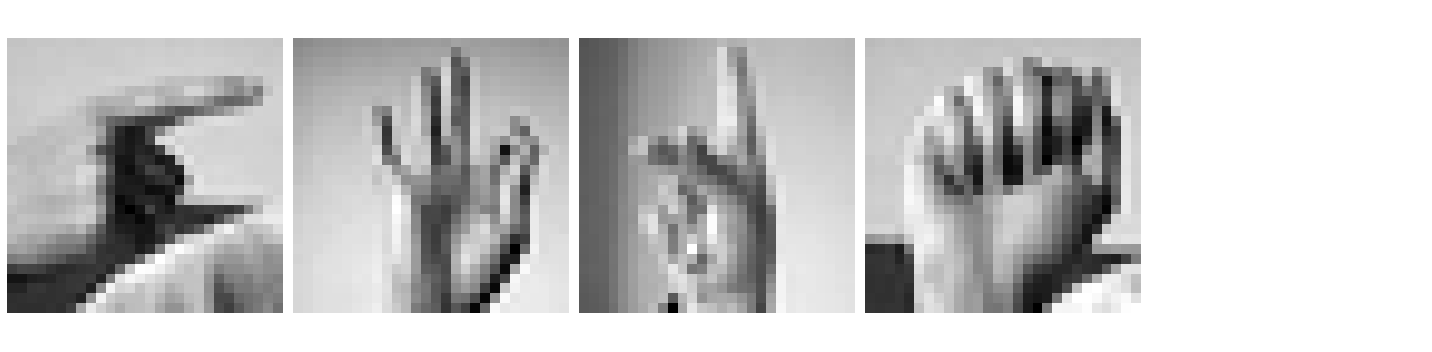

In [9]:
figure,axes=plt.subplots(nrows=1,ncols=5,figsize=(20,5), sharex=True, sharey=True)
ax=axes.ravel()
ax[0].imshow(X_test[0],cmap='gray')
ax[1].imshow(X_test[1],cmap=plt.cm.gray)
ax[2].imshow(X_test[2],cmap=plt.cm.gray)
ax[3].imshow(X_test[3],cmap=plt.cm.gray)

for x in ax:
    x.axis('off')
figure.tight_layout()
plt.show()

Reshape the data since a 4 dimensional input is required.

In [10]:
X_train = X_train.reshape((27455, 28, 28, 1))  # Get data as 27455 28x28 grayscale images
X_test = X_test.reshape((7172, 28, 28, 1))

Convert the labels to its one-hot encoded representation.

In [11]:
alphabet = y_test
y_train = to_categorical(y_train, num_classes=26)
y_test = to_categorical(y_test, num_classes=26)

The code below is executed when background removal is performed.

In [12]:
def nothing(x):
    pass

def with_bg_removal(model, image_frame):
    global s
    global is_hand_hist_created
    global hand_hist
    global no_frames
    #print(is_hand_hist_created)
    if not is_hand_hist_created:
        cv.rectangle(image_frame, (0, 420), (700, 600), (64, 64, 226), -1)
        cv.putText(image_frame, "Please ensure your hand fits within the ROI and your hand covers all green squares.",
                   (5, 450), cv.FONT_HERSHEY_COMPLEX, 0.42, (0, 0, 0), lineType=cv.LINE_AA)
        cv.putText(image_frame, "Stay in this position for roughly 5 seconds and press 'z' when you're ready!",
                   (15, 470),
                   cv.FONT_HERSHEY_COMPLEX, 0.42, (0, 0, 0), lineType=cv.LINE_AA)

    if cv.waitKey(1) & 0xFF == ord('z'):
        is_hand_hist_created = True
        hand_hist = hand_histogram(image_frame)

    if is_hand_hist_created==True:
        hist_mask_image = hist_masking(image_frame, hand_hist)
        hist_mask_image = cv.erode(hist_mask_image, None, iterations=2)
        hist_mask_image = cv.dilate(hist_mask_image, None, iterations=2)
        test = image_frame[60:320, 10:320]
        cropped_area = hist_mask_image[60:320, 10:320]
        cv.imshow("Background Removed", cropped_area)
        gray = cv.cvtColor(cropped_area, cv.COLOR_BGR2GRAY)
        square = cv.resize(gray, (28, 28), interpolation=cv.INTER_AREA).astype(np.uint8)
        new_gray = square[np.newaxis, :, :, np.newaxis].astype(np.uint8)
        pred_probab, pred_class = make_prediction(model, new_gray)
        alphabet = Map[pred_class]
        cv.putText(image_frame, alphabet, (100, 100), cv.FONT_HERSHEY_COMPLEX, 4.0, (0, 255, 0),
                   lineType=cv.LINE_AA)
    else:
        image_frame = draw_rect(image_frame)
        
    cv.rectangle(image_frame, (320, 60), (10, 320), (0, 255, 0), 2)
    cv.imshow("Video Feed", image_frame)
    s = cv.getTrackbarPos(switch, 'Video Feed')
    if s == 0:
        no_frames = 0
        if(cv.getWindowProperty("Background Removed", cv.WND_PROP_VISIBLE)==1):
            cv.destroyWindow("Background Removed")


The code below is executed when we do not perform background removal.

In [13]:
def without_bg_removal():
    global no_frames
    global is_hand_hist_created
    global s
    cropped_area = image_frame[60:320, 10:320]
    gray = cv.cvtColor(cropped_area, cv.COLOR_BGR2GRAY)
    square = cv.GaussianBlur(gray, (3, 3), 20)
    square = cv.resize(square, (28, 28), interpolation=cv.INTER_AREA).astype(np.uint8)

    new_gray = square[np.newaxis, :, :, np.newaxis]
    pred_probab, pred_class = make_prediction(model, new_gray)
    alphabet = Map[pred_class]
    if no_frames < 80:
        cv.rectangle(image_frame, (0, 420), (700, 600), (64, 64, 226), -1)
        cv.putText(image_frame, "Please ensure that your background is clear/ white & free of objects", (15, 450),
                   cv.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), lineType=cv.LINE_AA)

    cv.putText(image_frame, alphabet, (100, 100), cv.FONT_HERSHEY_COMPLEX, 4.0, (0, 255, 0),
               lineType=cv.LINE_AA)

    cv.rectangle(image_frame, (320, 60), (10, 320), (0, 255, 0), 2)
    no_frames += 1
    cv.imshow("Video Feed", image_frame)
    s = cv.getTrackbarPos(switch, 'Video Feed')
    if s == 1:
        no_frames = 0
        is_hand_hist_created = False


Define a dictionary to map the label's numerical representation to its alphabetical representation.

In [14]:
Map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', \
       12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
       24: 'Y'}

If you wish to re-train the model, please uncomment the line below.

In [15]:
#create_model()

Load the pretrained model named 'the_weights.h5'. If you re-trained above, please replace the parameter to the load_model function to be 'new_weights.h5'.

In [16]:
model = load_model('the_weights.h5')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


The code below sets up the interface and establishes the while loop that is executed to process each frame of the webcam stream. The code executed is dependent on whether the user has selected whether background removal is performed or not.  Executing the cell below will open 2 windows (one for the interface and the other to display a sign language chart). To close all the tabs, please press 'q'.

In [17]:

no_frames = 0
cv.namedWindow("Video Feed")

switch = ""
cv.createTrackbar(switch, 'Video Feed', 0, 1, nothing)
s = cv.getTrackbarPos(switch, 'Video Feed')

chart = cv.imread('data/chart.png', cv.IMREAD_COLOR).astype(np.uint8)
# Fix the path to the image!
Camera = cv.VideoCapture(0)
while Camera.isOpened():
    cv.imshow("Sign Language Chart", chart)
    ret, image_frame = Camera.read()
    image_frame = cv.flip(image_frame, flipCode=1)
    cv.putText(image_frame, "Without Background Removal", (60, 20), cv.FONT_HERSHEY_COMPLEX, 0.3, (255, 255, 255),
               lineType=cv.LINE_AA)
    cv.putText(image_frame, "With Background Removal", (500, 20), cv.FONT_HERSHEY_COMPLEX, 0.3, (255, 255, 255),
               lineType=cv.LINE_AA)
    if s == 1:
        with_bg_removal(model, image_frame)
    else:
        without_bg_removal()

    key_press = cv.waitKey(1) & 0xFF
    
    if key_press == ord("q") or cv.getWindowProperty("Video Feed", cv.WND_PROP_VISIBLE) < 1 or  cv.getWindowProperty("Sign Language Chart", cv.WND_PROP_VISIBLE) < 1:
        break

Camera.release()
cv.destroyAllWindows()

## Below, we present the evaluation results of the above model.

The cell below evaluates the accuracy of the model on the testing data.

In [18]:
print(model.evaluate(x=X_test,y=y_test,batch_size=32)[1])

7172/7172 [==============================] - 1s 149us/step
0.9652816653251648


The cell below computes the precision and recall of our model for each alphabet.

In [19]:
results = model.predict_classes(X_test)
print(metrics.classification_report(alphabet,results,target_names=Map.values()))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       331
           B       1.00      1.00      1.00       432
           C       0.95      1.00      0.97       310
           D       1.00      1.00      1.00       245
           E       1.00      1.00      1.00       498
           F       1.00      1.00      1.00       247
           G       0.93      0.78      0.85       348
           H       0.94      0.95      0.95       436
           I       0.93      1.00      0.96       288
           K       1.00      0.94      0.97       331
           L       1.00      1.00      1.00       209
           M       1.00      1.00      1.00       394
           N       1.00      1.00      1.00       291
           O       1.00      0.93      0.97       246
           P       1.00      1.00      1.00       347
           Q       0.92      1.00      0.96       164
           R       0.83      0.72      0.77       144
           S       0.91    

The function below is used to produce the confusion matrix.

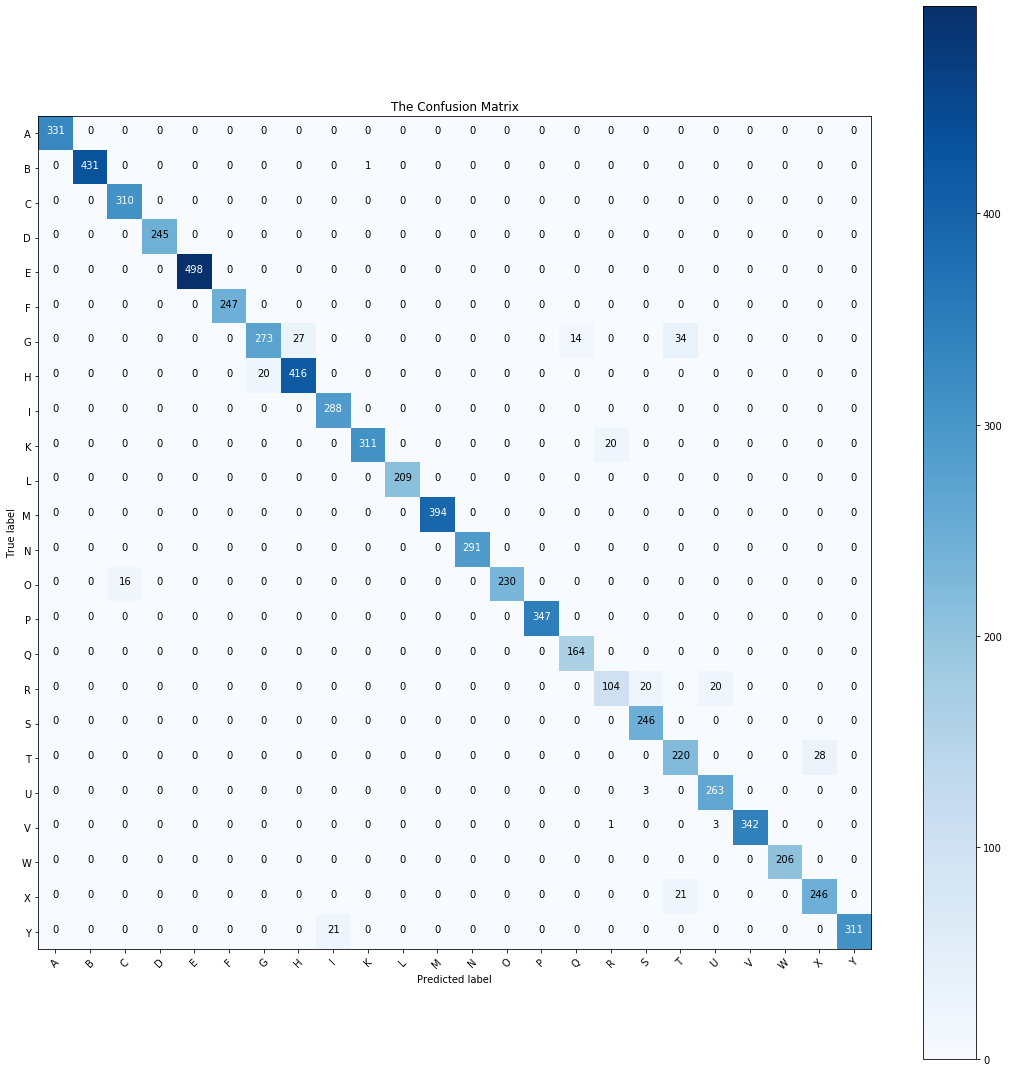

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


conf = metrics.confusion_matrix(alphabet, results)
plt.figure(figsize=(15,15))
plot_confusion_matrix(conf, classes=Map.values(), normalize=False, title="The Confusion Matrix")
plt.show()



The cell below produces the graphs illustrating the progression of the model's loss and accuracy as the epochs increases

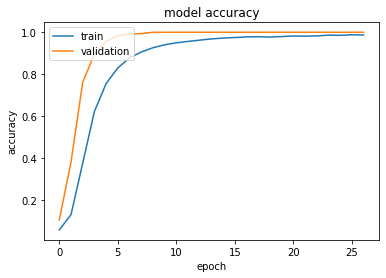

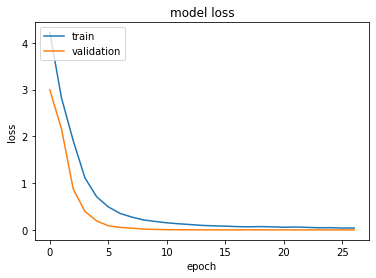

In [21]:
history=np.load('my_history.npy',allow_pickle='TRUE').item()

# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()